In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *

**Reflect Tables into SQLAlchemy ORM**

In [4]:
#Set of libraries to connect Python to SQL and mapping 
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
#Can view all the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB!!!
session = Session(engine)

**Exploratory Precipitation Analysis**

In [10]:
# Find the most recent date in the data set.
#Create query to retrieve the past 12 month of data and plot
most_current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_current_date = str(most_current_date)[2:-3]
print(f'Most current date in the dataset {most_current_date}')

Most current date in the dataset 2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastdate = datetime.strptime(most_current_date,'%Y-%m-%d')
# Calculate the date one year from the last date in data set.
prev_year = lastdate + relativedelta(months=-12)
filter_date = prev_year.strftime('%Y-%m-%d')
#Retrive the dataset and the precipitation scores 
last12mnth_df = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=filter_date).all()

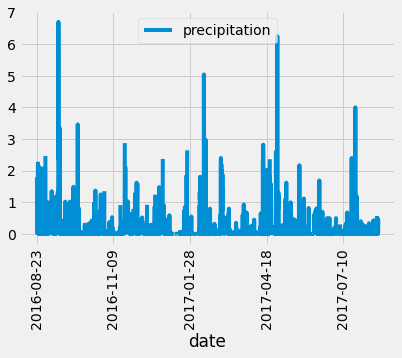

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
pre_df = pd.DataFrame(last12mnth_df).set_index('date')

prcp_data = pre_df.rename(columns={'prcp':'precipitation'}).sort_index()

#plot
prcp_data.plot()
plt.xticks(rotation=90)
plt.legend(loc=9)
plt.savefig("precipitation_analysis.png")
plt.show()

In [13]:
#Use Pandas to print the summary statistics for the precipitation data
prcp_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


**Exploratory Station Analysis**

In [14]:
# Design a query to calculate the total number stations in the dataset
number_station = session.query(Station.id).count()
print(f'A total of {number_station} stations in the dataset')

A total of 9 stations in the dataset


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

active_station_df = pd.DataFrame(active_stations, columns=['station','observations'])\
                                    .sort_values(by='observations', ascending=False)
active_station_df.head()

,station,observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stations = active_station_df.head()
mostactive_df = most_active_stations.iloc[0]['station']

#calculate the lowest temp
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==mostactive_df).all()


#calculate the highest temp
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==mostactive_df).all()

    
#calculate the highest temp
avr_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==mostactive_df).all()
print(mostactive_df)
for temp in low_temp : print(low_temp)
for temp in high_temp: print(high_temp)
for temp in avr_temp: print(avr_temp)

USC00519281
[(54.0,)]
[(85.0,)]
[(71.66378066378067,)]


Text(0.5, 0, 'Temperature')

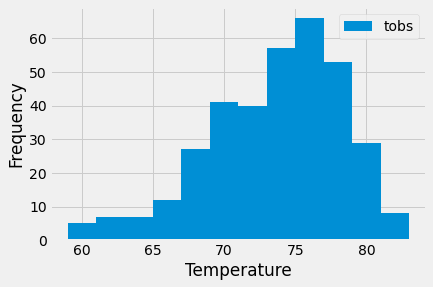

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12month = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>=filter_date)\
                                            .filter(Measurement.station==mostactive_df).all()

temp_12moth_df = pd.DataFrame(last12month)

ax = temp_12moth_df.plot.hist(bins=12)
ax.set_xlabel('Temperature')

**Close Session**